____________________

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%pylab inline
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import  f1_score, accuracy_score
from utils import load_obj
from keras.models import load_model 
import seaborn as sns
from utils import inverse_ohe

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [4]:
# Путь к файлу с мета данными
meta_pth = '/media/grigory/Data/ITMO_DATA/data_v_7_stc/meta/meta.txt'

# Пути к директориям с аудиофайлами.
train_audio_pth = '/media/grigory/Data/ITMO_DATA/data_v_7_stc/audio'
test_audio_pth = '/media/grigory/Data/ITMO_DATA/data_v_7_stc/test'

extracted_data = 'data/extracted'

# Имена файлов с извлечёнными признаками для dense сети, линейных моделей и деревьев.
extracted_train = 'features_labels_train' 
extracted_test = 'features_labels_test'

загружаем извлечённые признаки

In [5]:
X, names, labels = load_obj(os.path.join(extracted_data, extracted_train))
X_test, names_test = load_obj(os.path.join(extracted_data, extracted_test))[:2]

In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# кодируем таргет
le = LabelEncoder()
y = le.fit_transform(labels)
ohe =  OneHotEncoder()
y_ohe = ohe.fit_transform(y.reshape(-1,1))

In [7]:
n_features = X.shape[1]
n_classes = y.max()+1
print('Число классов: {}\nЧисло признаков: {}\nЧисло сэмплов: {}'.format(n_classes, n_features, y.shape[0]))

Число классов: 8
Число признаков: 193
Число сэмплов: 11307


> для правильной валидации нужно учитывать, что некоторые сэмплы являются частями одной записи.
Если части одной записи будут разрознено находится и в train и в val, то произойдёт утечка меток в валидацию.

Поэтому сперва найдём уникальные записи и сгруппируем все фрагменты по принадлежности к отдельной записи.

In [8]:
groups_le = LabelEncoder()
unique_samples = pd.Series(names).apply(lambda x: x.split('time_stretch')[0].strip('.wav').strip('_'))
groups = groups_le.fit_transform(unique_samples)

In [9]:
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, train_size=0.8, random_state=7)

idxs = np.arange(X.shape[0])
tr_idxs, val_idxs = next(iter(gss.split(idxs, groups=groups)))

In [10]:
# сплитим...
# имена файлов
names_train, names_val = names[tr_idxs], names[val_idxs]
# извлечённые признаки
X_train, X_val = X[tr_idxs], X[val_idxs]
# метки для sklearn
y_train, y_val = y[tr_idxs], y[val_idxs]
# метки для сеток
y_ohe_train, y_ohe_val = y_ohe[tr_idxs], y_ohe[val_idxs]

In [11]:
groups_train, groups_val = groups[tr_idxs], groups[val_idxs]

## Нелинейные модели

#### бустинг и лес

In [12]:
%%time
# !pip install lightgbm
import lightgbm as lgb
from lightgbm.sklearn import LGBMClassifier

lgbm = LGBMClassifier(learning_rate=1e-2,
#                        reg_alpha=1e-2,
#                        reg_beta=1e-1,
#                      valid_sets=[X_val, y_val],
                       random_state=7,
                     n_estimators=500)
lgbm.fit(X_train, y_train);

# Оцениваем качества на отложенной выборке
print('Scoring...')
tr_score = lgbm.score(X_train, y_train)
val_score = lgbm.score(X_val, y_val)
print('Acc:: Train score: {}, val score: {}'.format(tr_score, val_score))

Scoring...


/home/grigory/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Acc:: Train score: 1.0, val score: 0.9457910973997355
CPU times: user 7min 50s, sys: 444 ms, total: 7min 50s
Wall time: 1min


/home/grigory/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


лучшие параметры  для случайного леса были найдены с помощью RandomizedSearch. Поиск занимает около 40 мин.

Параметры были записаны  в best_params, так что ячейки с перебором закомиченна

In [13]:
# # ~ 40 min
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# from sklearn.ensemble import RandomForestClassifier

# estimator = RandomForestClassifier(random_state=7)
# gs_params = dict(
#     max_depth=[3,10, 15, 50, 100, 150],
#     n_estimators=[5,10, 25, 50, 100, 150, 250],
#     max_features= list(np.linspace(0.1,1,20)) + ['auto', 'sqrt'],
#     bootstrap=[True, False]
# )
# gs = RandomizedSearchCV(estimator, gs_params, n_jobs=-1, random_state=7,
#                         n_iter=100, verbose=2)#GridSearchCV(trees, gs_params)
# gs.fit(X_train, y_train, groups=groups_train);

In [14]:
# trees = gs.best_estimator_
from sklearn.ensemble import RandomForestClassifier
best_params = {'n_estimators': 100, 
               'max_features': 0.19473684210526315, 
               'max_depth': 100, 'bootstrap': False,
               'random_state':12}
trees = RandomForestClassifier(**best_params)
trees.fit(X_train, y_train)
# Оцениваем качества на отложенной выборке
print('Scoring...')
tr_score = trees.score(X_train, y_train)
val_score = trees.score(X_val, y_val)
print('Acc:: Train score: {}, val score: {}'.format(tr_score, val_score))

Scoring...
Acc:: Train score: 1.0, val score: 0.9519612163948876


## Линейные модели

In [15]:
# # 5 min
# from sklearn.linear_model import LogisticRegression
# logreg = LogisticRegression(random_state=7)
# gs_params = dict(
#     C = np.logspace(-3,3,10),
# )
# gs = RandomizedSearchCV(logreg, gs_params, n_jobs=-1, random_state=7,
#                         n_iter=10, verbose=1)#GridSearchCV(trees, gs_params)
# gs.fit(X_train, y_train, groups=groups_train);

# logreg = gs.best_estimator_
# logreg.fit(X_train, y_train)
# # Оцениваем качества на отложенной выборке
# print('Scoring...')
# tr_score = logreg.score(X_train, y_train)
# val_score = logreg.score(X_val, y_val)
# print('Acc:: Train score: {}, val score: {}'.format(tr_score, val_score))

In [16]:
from sklearn.linear_model import LogisticRegression
best_params = {'C': 1000.0}
logreg = LogisticRegression(**best_params, random_state=7)
logreg.fit(X_train, y_train)
# Оцениваем качества на отложенной выборке
print('Scoring...')
tr_score = logreg.score(X_train, y_train)
val_score = logreg.score(X_val, y_val)
print('Acc:: Train score: {}, val score: {}'.format(tr_score, val_score))

Scoring...
Acc:: Train score: 0.9487718521796857, val score: 0.8990744821507272


_________

#### онлайн-обучение нейонных сеток

Обзор методов на нейронных сетях:

- http://www.fim.uni-passau.de/fileadmin/files/lehrstuhl/schuller/Publications/Amiriparian17-SSC.pdf
- https://github.com/libphy/which_animal
- https://github.com/jaron/deep-listening
- https://musicinformationretrieval.com/mfcc.html

Тестировались:
    - полносвязанные сети
    - lstm
    - свёрточные

Самые лучшие результаты показали полносвязные сети.


*Коротко о подборе оптимальной архитектуры для Dense сети*:

<img width=350 src="https://habrastorage.org/webt/sg/7t/tu/sg7ttuirleaml3_j7dwo2tn0iqs.png">

In [74]:
import keras
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from models import (build_deep_dense, build_conv_seq, build_lstm_seq)
from callbacks import AggregatedPredictions, CyclicLR

##### Dense сеть

In [75]:
# normalize
mean_ = np.mean(X_train, axis=0)
std_ = np.std(X_train, axis=0)

In [90]:
K.clear_session()
model = build_deep_dense(n_features, n_classes)


model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(1e-4), 
              metrics=['accuracy'])
callbacks = [
    EarlyStopping(patience=20, monitor='val_loss'),
    ModelCheckpoint('models_weights/net_ff.h5', monitor='val_loss', 
                    verbose=1, save_best_only=True, period=4),
    AggregatedPredictions((X_val - mean_)/std_, y_val, ohe, on_each=1, best=6),
    CyclicLR(base_lr=1e-4, max_lr=6e-4),  # бывают проблемы с этим, повторно выполнтить ячейку с импортом этого пакета
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, 
                      patience=10, verbose=1, mode='auto')
    
]

model.fit((X_train - mean_)/std_, y_ohe_train.todense(), 
          epochs=300, batch_size=250, 
          verbose=0,
          validation_data=[(X_val - mean_)/std_, y_ohe_val.todense()],
         callbacks=callbacks)

Epoch 00004: val_loss improved from inf to 0.57691, saving model to models_weights/net_ff.h5
Best ensemble of [1, 2, 3, 4] has score 0.8070
Best ensemble of [1, 2, 3, 4, 5] has score 0.8237
Epoch 00008: val_loss improved from 0.57691 to 0.33133, saving model to models_weights/net_ff.h5
Best ensemble of [2, 3, 4, 5, 7, 6] has score 0.8748
Best ensemble of [3, 4, 5, 7, 6, 8] has score 0.8907
Best ensemble of [4, 5, 7, 6, 8, 9] has score 0.9022
Best ensemble of [5, 7, 6, 8, 9, 10] has score 0.9101
Epoch 00012: val_loss improved from 0.33133 to 0.28749, saving model to models_weights/net_ff.h5
Best ensemble of [7, 6, 8, 9, 11, 10] has score 0.9198
Best ensemble of [6, 8, 9, 11, 12, 10] has score 0.9233
Best ensemble of [8, 9, 13, 11, 12, 10] has score 0.9255
Epoch 00016: val_loss improved from 0.28749 to 0.28309, saving model to models_weights/net_ff.h5
Best ensemble of [13, 11, 12, 15, 14, 10] has score 0.9268
Best ensemble of [11, 12, 16, 15, 14, 10] has score 0.9277
Best ensemble of [12

In [91]:
epochs = [int(t.split('.')[0].split('_')[1]) for t in os.listdir('tmp')]

In [92]:
class Aggregator:
    def __init__(self, epochs, tmp_dir='tmp'):
        self.epochs = epochs
        self.tmp_dir = tmp_dir
        
    def predict_proba(self, X):
        return self.predict(X)
        
    def predict(self, data):
        preds = []
        for epoch in self.epochs:
            model = load_model(os.path.join(self.tmp_dir, 'tmp_{}.h5'.format(epoch)))
            pred = model.predict((data-mean_)/std_)
            preds.append(pred)
            K.clear_session()
            del model
        return np.array(preds).mean(axis=0)
    
agg_dense = Aggregator(epochs)
preds = agg_dense.predict(X_val)
preds = inverse_ohe(preds, ohe)
print(accuracy_score(y_val, preds))

0.9440282062582636


In [93]:
from sklearn.naive_bayes import BernoulliNB
nbc = BernoulliNB()
nbc.fit(X_train, y_train)
nbc.score(X_train, y_train)

0.505864129232131

In [94]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3, metric='cosine')
knn.fit(X_train, y_train)

knn.score(X_val, y_val)

0.9338915821947995

Выводы по моделям:

### TODO обновить выводы.
> Наилучшими моделями(без яростного тюнинга параметров) оказались полносвязная сеть, бустинг и случайный лес. В целом, можно сказать, что они дают  сопоставимые результаты, но если посмотреть на:
    - распределние плотности вероятности для максимальных классов по всей выборке
    - разницу точности предсказаний на трейне и валидации 
...можно легко заметить, что модели переобучились. Чтобы бороться с переобучением сделаем простой блендинг.

## Блендинг

In [95]:
from sklearn.metrics import accuracy_score
from utils import blend, blending_weights_search, multiclass_auc
from itertools import product
weights = [0.20, 0.25,  0.15, 0.15, 0.15, 0.10]
print(sum(weights))
models = [trees, agg_dense, logreg, lgbm, nbc, knn]
print('train')
preds = blend(models, X_train, weights)
print( accuracy_score(y_train, preds), multiclass_auc(y_train, preds, metric='pc'))

print('validation')
preds = blend(models, X_val, weights)
print( accuracy_score(y_val, preds), multiclass_auc(y_val, preds, metric='pc'))

1.0
train
0.9997787121044479 0.9995068254411965
validation
0.9629792860290877 0.9408084321241358


```
1.0
train
0.9995574242088958 0.9992236323875088
validation
0.9651828999559278 0.9467950234765703
```

### SQ метрика

>  Делаете перебор по всем значениям порога. Для каждого значения порога рассчитываете по базе точность и вероятность ложного срабатывания. Наносим полученные значения в соответствующих осях, получаем график точности от вероятности ложного срабатывания

-0.7294382924292239

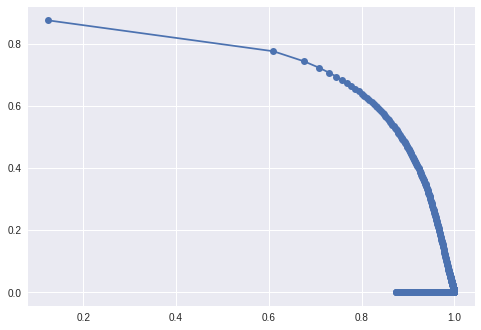

In [66]:
def evaluate(data, labels, eps=1e-8):
    def sq_metric(y_true, probas):
        from sklearn.metrics import recall_score, precision_score, accuracy_score
        thresholds = np.linspace(0,1,1000)
        accs, fprs = [], []
        classes = set(y_true)
        for th in thresholds:
            tmp_acc = []
            tmp_fpr = []
            for  cls in classes:
                y_pred = (probas[:, cls] > th).astype(np.uint8)
                y_gt = (y_true==cls).astype(np.uint8)
                # Считаем точность, как доля правильных ответов среди всех
                acc = accuracy_score(y_gt, y_pred)
                # Счиатем лоное срабатывание
                fpr =  ((y_pred==1) & (y_gt==0)).sum() / (y_pred.sum()+eps)
                tmp_acc.append(acc)
                tmp_fpr.append(fpr)
            accs.append(np.array(tmp_acc).mean())
            fprs.append(np.array(tmp_fpr).mean())
        return accs, fprs
    
    probas = blend(models, data, weights, proba=True)
    accs, fprs = sq_metric(labels, probas)
    plt.plot(accs, fprs, '-o');
    return np.trapz(accs, x=fprs)

evaluate(X_train, y_train)

### Предикт теста и подготовка сабмита

https://mlschool.speechpro.ru/core/results

In [67]:
preds = blend(models, X_test, weights=weights, proba=True)

In [68]:
def prepare_submit(names, preds, ohe=ohe, le=le):
    pred_labels = inverse_ohe(preds, ohe)
    pred_names = le.inverse_transform(pred_labels)
    df = pd.DataFrame(list(zip(names, preds.max(axis=1), pred_names)), columns=['file','prob','label'])
    return df
                      
submit_df = prepare_submit(names_test, preds)

/home/grigory/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [69]:
submit_df.to_csv('result.txt', sep='\t', header=None, index=None)